In [1]:
import numpy as np

train_x = np.load('data/x_train.npz')['arr_0']
test_x = np.load('data/x_test.npz')['arr_0']
train_y = np.load('data/y_train.npz')['arr_0']
test_y = np.load('data/y_test.npz')['arr_0']

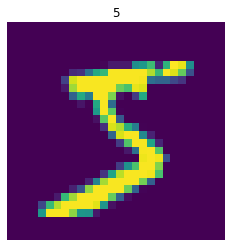

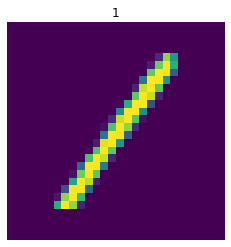

In [2]:
import matplotlib.pyplot as plt

def show_img(X, title: str = ''):
    plt.imshow(X)
    plt.axis('off')
    plt.title(f'{title}')
    plt.show()

index = 0
show_img(train_x[index], str(train_y[index]))
index = 1003
show_img(train_x[index], str(train_y[index]))

In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

### Activation functions

1. Identity AF

In [5]:
def identity(x):
    return x

2. Sigmoid

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

3. Tanh 

In [7]:
def tanh(x):
    return (2 * sigmoid(2*x)) - 1

4. Relu

In [8]:
def relu(x):
    return np.maximum(0, x)

5. Leaky relu

In [9]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha*x, x)

6. Softmax

In [10]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x/np.sum(exp_x)

In [11]:
x = np.array([1, 2, 3])
softmax_x = softmax(x)
print(softmax_x)
np.argmax(softmax_x)

[0.09003057 0.24472847 0.66524096]


2

### Initial weights

1. Zero

In [12]:
def zero_init(t1, t2=1):
    """
    Parameters:
    - t1 (int): Number of neurons in the current layer.
    - t2 (int): Number of neurons in the next layer.
    """
    return np.zeros((t1, t2))

2. Random

In [13]:
def random_init_s(t1, t2=1, std_dev=0.01):
    return np.random.normal(0, std_dev, size=(t1, t2))

In [14]:
def random_init_l(t1, t2=1, std_dev=1.0):
    return np.random.normal(0, std_dev, size=(t1, t2))

3. Xavier

In [15]:
def xavier_init(t1, t2=1):
    return np.random.randn(t1, t2) * np.sqrt(1/ t1)

4. He

In [16]:
def he_init(t1, t2=1):
    std_dev = 2/t1
    return np.random.normal(0, std_dev, size=(t1, t2))

In [17]:
def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15  # to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip values to avoid log(0) or log(1)

    # Binary Cross Entropy Loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return loss

In [18]:
# Calculate the derivative of BCE with respect to prediction (y_pred)
def bce_derivative(y_true, y_pred):
    # y_true_expanded = np.expand_dims(y_true, axis=1)
    epsilon = 1e-15  # Add a small epsilon to avoid division by zero
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

In [19]:
def categorical_cross_entropy_loss(y_true, y_pred):
    # Avoiding division by zero by adding a small epsilon value
    epsilon = 1e-15
    # Compute the loss
    loss = -np.sum(y_true * np.log(y_pred + epsilon))
    # Normalize the loss by the number of samples
    loss /= len(y_true)
    return loss

In [20]:
import numpy as np

def categorical_cross_entropy_derivative(y_pred, y_true):
    # Ensure dimensions match
    assert y_pred.shape == y_true.shape, "Shape mismatch between y_pred and y_true"
    
    # Calculate the derivative
    return (1 / y_pred.shape[0]) * (y_pred - y_true)


In [21]:
def identity_derivative(x):
    return np.ones_like(x)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu_derivative(x):
    return np.where(x <= 0, 0, 1)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x <= 0, alpha, 1)

def softmax_derivative(x):
    s = softmax(x)
    d_softmax = np.diag(s)
    return np.outer(s, np.ones_like(s)) * (d_softmax - np.outer(np.ones_like(s), s))


In [22]:
def mlp(l, t, n, p, f, init):
    # l is a scalar for the number of layers
    # t is a list of size l that each item indicates the number of neurons in each layer
    # n is the number of features of input
    # p is the number of patterns
    # f is a list of size l that each item indicates the activation function of each layer
    # init is the way that we initialize weights

    t2 = [n] + t  # Add input layer size to the beginning of the list

    # Initialize weights using Xavier initialization
    if(init=='zero'):
        weights = [zero_init(t2[i], t2[i+1]) for i in range(l)]
        biases = [zero_init(t2[i+1]) for i in range(l)]
    elif(init=='rand_s'):
        weights = [random_init_s(t2[i], t2[i+1]) for i in range(l)]
        biases = [random_init_s(t2[i+1]) for i in range(l)]       
    elif(init=='rand_l'):
        weights = [random_init_l(t2[i], t2[i+1]) for i in range(l)]
        biases = [random_init_l(t2[i+1]) for i in range(l)] 
    elif(init=='xavier'):
        weights = [xavier_init(t2[i], t2[i+1]) for i in range(l)]
        biases = [xavier_init(t2[i+1]) for i in range(l)]     
    elif(init=='he'):
        weights = [he_init(t2[i], t2[i+1]) for i in range(l)]
        biases = [he_init(t2[i+1]) for i in range(l)] 

    model = {
        "l": l,
        "t": t,
        "n": n,
        "p": p,
        "f": f,
        "weights": weights,
        "biases": biases
    }

    return model

In [23]:
def forward(model, datas, y_trues):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["final_weights"]
    biases = model["final_biases"]

    count = 0

    for j in range(datas.shape[1]):
            data = datas[j]
            y_true = y_trues[j]
            onehot = np.zeros((10,1))
            onehot[y_true] = 1
            y_true = onehot

            dict = {}

            dict["a0"] = data

            # Calculate sigma w*x + b for each layer
            layer_outputs = [data] # Initial layer is the input data

            for i in range(1, l+1):  # Iterate over layers
                # Calculate the weighted sum (sigma w*x + b)
                weighted_sum = np.zeros(np.shape(biases[i-1]))
                for k in range(len(biases[i-1])):
                    weighted_sum[k] = np.dot(weights[i-1].T,layer_outputs[-1])[k] + biases[i-1][k]

                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)    
                elif f[i-1] == 'softmax':
                    layer_output = softmax(weighted_sum) 
                    
                dict["a"+str(i)] = layer_output
                # Append the layer output to the list
                layer_outputs.append(layer_output)

            y_pred = dict["a"+str(len(t))]
            loss = binary_cross_entropy_loss(y_true, y_pred)

            y = predict(y_pred)

            if(y == y_true):
                count+=1
    acc = count/len(y_trues)

    return loss, acc

In [24]:
def predict(y):
    y_pred = []
    for i in range(len(y)):
        y_pred.append(np.argmax(y))
    return y_pred

In [25]:
#simple with no batch
def backpropagation(model, epochs, datas, y_trues, learning_rate, test_x, test_y):
    l = model["l"]
    t = model["t"]
    n = model["n"]
    p = model["p"]
    f = model["f"]
    weights = model["weights"]
    biases = model["biases"]

    losses = []
    losses_test = []
    acc = []
    acc_test = []

    for epoch in range(epochs):
        for j in range(datas.shape[1]):
            data = datas[j]
            y_true = y_trues[j]
            onehot = np.zeros((10,1))
            onehot[y_true] = 1
            y_true = onehot

            dict = {}      

            a = np.zeros((len(data),1))
            for k in range(len(data)):
                a[k][0] = data[k]
            dict["a0"] = a


            # Calculate sigma w*x + b for each layer
            layer_outputs = [data] # Initial layer is the input data

            for i in range(1, l+1):  # Iterate over layers
                # Calculate the weighted sum (sigma w*x + b)
                weighted_sum = np.zeros(np.shape(biases[i-1]))
                for k in range(len(biases[i-1])):
                    weighted_sum[k] = np.dot(weights[i-1].T,layer_outputs[-1])[k] + biases[i-1][k]

                dict["z" + str(i)] = weighted_sum

                # Apply activation function
                if f[i-1] == 'identity':
                    layer_output = identity(weighted_sum)                
                elif f[i-1] == 'sigmoid':
                    layer_output = sigmoid(weighted_sum)
                elif f[i-1] == 'tanh':
                    layer_output = tanh(weighted_sum)                    
                elif f[i-1] == 'relu':
                    layer_output = relu(weighted_sum)
                elif f[i-1] == 'leaky_relu':
                    layer_output = leaky_relu(weighted_sum)
                elif f[i-1] == 'softmax':
                    layer_output = softmax(weighted_sum)

                dict["a"+str(i)] = layer_output
                # Append the layer output to the list
                layer_outputs.append(layer_output)

            y_pred = dict["a"+str(len(t))]
            loss = binary_cross_entropy_loss(y_true, y_pred)
            
#             print(y_true.shape,y_pred.shape)

            if j % 500 == 0:
                if epoch %10 ==0:
                    print(f"Epoch {epoch}, data{j}, Loss: {loss}")

            # Initialize gradients for weights and biases
            grad_weights = [np.zeros_like(weight) for weight in weights]
            grad_biases = [np.zeros_like(bias) for bias in biases]

            # Backward pass
            for i in range(l, 0, -1):
                # Derivative of the loss with respect to the weighted sum (z)
                d_loss_da = bce_derivative(y_true, dict["a" + str(i)])
                print(y_true.shape,dict["a" + str(i)].shape,"test")

                # Derivative of the weighted sum (z) with respect to the activation (a)             
                if f[i-1] == 'identity':
                    d_a_dz = identity_derivative(dict["z" + str(i)])                
                elif f[i-1] == 'sigmoid':
                    d_a_dz = sigmoid_derivative(dict["z" + str(i)])
                elif f[i-1] == 'tanh':
                    d_a_dz = tanh_derivative(dict["z" + str(i)])                   
                elif f[i-1] == 'relu':
                    d_a_dz = relu_derivative(dict["z" + str(i)])
                elif f[i-1] == 'leaky_relu':
                    d_a_dz = leaky_relu_derivative(dict["z" + str(i)])                   
                elif f[i-1] == 'softmax':
                    d_a_dz = softmax_derivative(dict["z" + str(i)])  
                    
                # Derivative of the activation (a) with respect to the weighted sum (z)
#                 d_loss_dz = np.zeros((len(d_loss_da),1))
#                 for k in range (len(d_loss_da)):
                print(dict["z" + str(i)].shape)
                print(d_loss_da.shape, d_a_dz.shape)
                print((np.dot(d_loss_da,d_a_dz.T)).shape)
#                     d_loss_dz[k][0] = d_loss_da[k] * d_a_dz[k]
                d_loss_dz = np.dot(d_loss_da,d_a_dz.T)

                # Derivative of the weighted sum (z) with respect to the weights and biases
                d_loss_dw = np.dot(dict["a" + str(i-1)], d_loss_dz.T)              
                d_loss_db = d_loss_dz

                # Chain rule to calculate gradients
                grad_weights[i-1] = d_loss_dw
                grad_biases[i-1] = d_loss_db

            # Update weights and biases using gradient descent
            for i in range(l):
                for k in range(len(weights[i])):
                    weights[i][k] -= learning_rate * grad_weights[i][k]
                biases[i] -= learning_rate * grad_biases[i][0]
        
        model["final_weights"] = weights
        model["final_biases"] = biases
        
        loss , accuracy = forward(model, datas, y_trues)
        losses.append(loss)
        acc.append(accuracy)
        
        loss , accuracy = forward(model, test_x, test_y)
        losses_test.append(loss)
        acc_test.append(accuracy)
        

    model["final_weights"] = weights
    model["final_biases"] = biases
    model["losses"] = losses
    model["acc"] = acc
    model["losses_test"] = losses_test
    model["acc_test"] = acc_test
    return model

In [26]:
# Softmax function
def softmax(x):
    exp_scores = np.exp(x)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


In [27]:
def softmax(x):
    # Shift input values by maximum value for numerical stability
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    exp_scores = np.exp(shifted_x)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

Epoch 1/25, Loss: 3.9620627830441415
Epoch 2/25, Loss: 2.8113689029315405
Epoch 3/25, Loss: 2.0580778825568466
Epoch 4/25, Loss: 1.7076589869130443
Epoch 5/25, Loss: 1.4857972644035509
Epoch 6/25, Loss: 1.329612382010202
Epoch 7/25, Loss: 1.205845613413762
Epoch 8/25, Loss: 1.113299763353273
Epoch 9/25, Loss: 1.0354101842246672
Epoch 10/25, Loss: 0.9733524323482697
Epoch 11/25, Loss: 0.9195622810670876
Epoch 12/25, Loss: 0.8748653971755294
Epoch 13/25, Loss: 0.8353363578365405
Epoch 14/25, Loss: 0.8014886167308438
Epoch 15/25, Loss: 0.7711776726112854
Epoch 16/25, Loss: 0.7446193087810541
Epoch 17/25, Loss: 0.7206161321930113
Epoch 18/25, Loss: 0.6991944021976956
Epoch 19/25, Loss: 0.679672642835221
Epoch 20/25, Loss: 0.6620022250261992
Epoch 21/25, Loss: 0.6458067528275543
Epoch 22/25, Loss: 0.6309851126412781
Epoch 23/25, Loss: 0.6173179179571389
Epoch 24/25, Loss: 0.6046968738128548
Epoch 25/25, Loss: 0.592985343526356
Test Accuracy: 0.8383


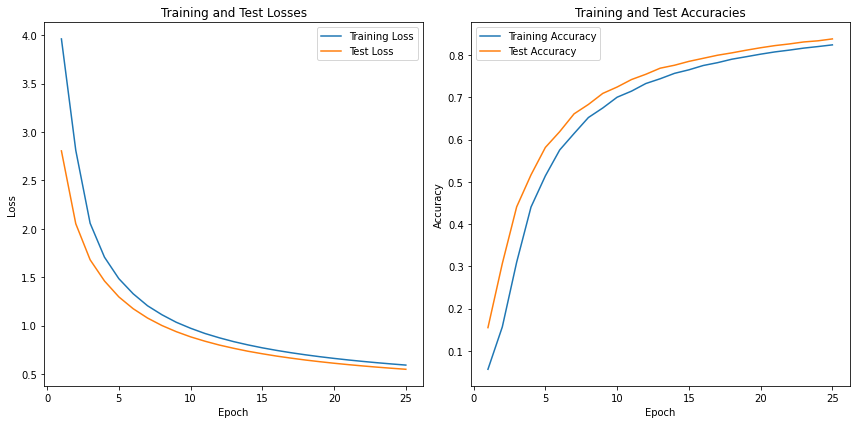

In [30]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 25

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    train_losses.append(train_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    test_losses.append(test_loss)
    
    # Calculate and store training accuracy
    train_predictions = np.argmax(a2, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)
    
    # Calculate and store test accuracy
    test_predictions = np.argmax(a2_test, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200, Loss: 3.6991439524055028
Epoch 2/200, Loss: 2.803386267248174
Epoch 3/200, Loss: 2.13963382776538
Epoch 4/200, Loss: 1.8026841817367425
Epoch 5/200, Loss: 1.493584320501514
Epoch 6/200, Loss: 1.3244693986451985
Epoch 7/200, Loss: 1.1935744061328826
Epoch 8/200, Loss: 1.0996913148661431
Epoch 9/200, Loss: 1.0241238789579685
Epoch 10/200, Loss: 0.9646168905169917
Epoch 11/200, Loss: 0.9133390906172016
Epoch 12/200, Loss: 0.8715221776766207
Epoch 13/200, Loss: 0.8341201927039348
Epoch 14/200, Loss: 0.8029304497697229
Epoch 15/200, Loss: 0.7742414809016429
Epoch 16/200, Loss: 0.7499116015087499
Epoch 17/200, Loss: 0.7270649168385339
Epoch 18/200, Loss: 0.70742728809858
Epoch 19/200, Loss: 0.6886495416549078
Epoch 20/200, Loss: 0.6723473194069175
Epoch 21/200, Loss: 0.6565699865982876
Epoch 22/200, Loss: 0.6427102666298712
Epoch 23/200, Loss: 0.6292001208913832
Epoch 24/200, Loss: 0.6172104508868586
Epoch 25/200, Loss: 0.605474169605338
Epoch 26/200, Loss: 0.5949465708332611
Ep

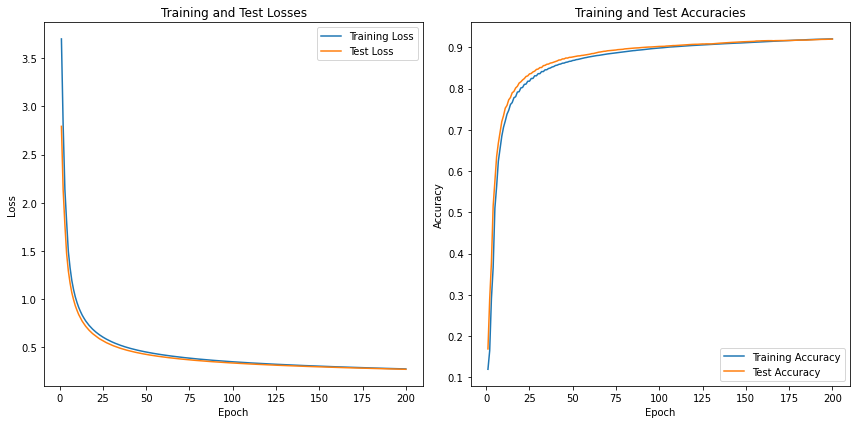

In [87]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    train_losses.append(train_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    test_losses.append(test_loss)
    
    # Calculate and store training accuracy
    train_predictions = np.argmax(a2, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)
    
    # Calculate and store test accuracy
    test_predictions = np.argmax(a2_test, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

with normalization

Epoch 1/200, Loss: 2.3030437373435895
Epoch 2/200, Loss: 2.303033371801041
Epoch 3/200, Loss: 2.3030230067096955
Epoch 4/200, Loss: 2.3030126419476353
Epoch 5/200, Loss: 2.3030022771265077
Epoch 6/200, Loss: 2.3029919126343366
Epoch 7/200, Loss: 2.3029815485651906
Epoch 8/200, Loss: 2.30297118501918
Epoch 9/200, Loss: 2.3029608220536164
Epoch 10/200, Loss: 2.3029504597358503
Epoch 11/200, Loss: 2.3029400977416685
Epoch 12/200, Loss: 2.3029297358052694
Epoch 13/200, Loss: 2.3029193744190084
Epoch 14/200, Loss: 2.302909013045804
Epoch 15/200, Loss: 2.3028986521434316
Epoch 16/200, Loss: 2.3028882921096128
Epoch 17/200, Loss: 2.302877932900516
Epoch 18/200, Loss: 2.302867574241626
Epoch 19/200, Loss: 2.3028572155891123
Epoch 20/200, Loss: 2.302846857338729
Epoch 21/200, Loss: 2.3028364989577748
Epoch 22/200, Loss: 2.3028261406739348
Epoch 23/200, Loss: 2.3028157825621083
Epoch 24/200, Loss: 2.302805424407891
Epoch 25/200, Loss: 2.302795066670573
Epoch 26/200, Loss: 2.3027847090285336
Epoc

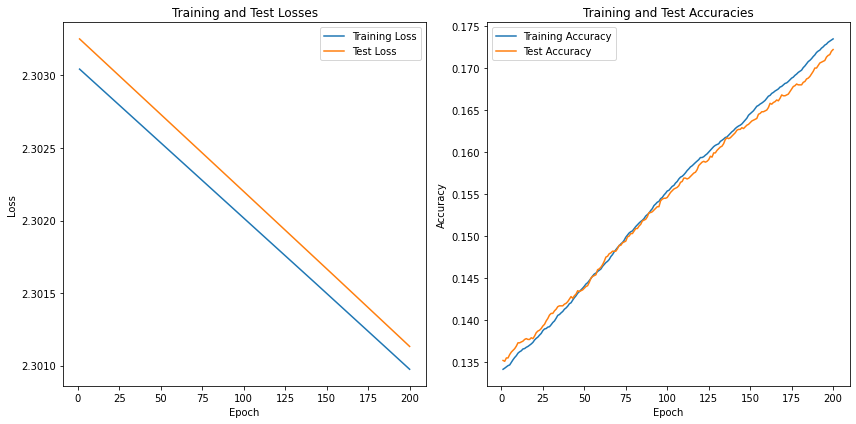

In [86]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x/255.0
X_test = test_x/255.0

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    train_losses.append(train_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    test_losses.append(test_loss)
    
    # Calculate and store training accuracy
    train_predictions = np.argmax(a2, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)
    
    # Calculate and store test accuracy
    test_predictions = np.argmax(a2_test, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

with standardization

In [31]:
# Standardize input data
def standardize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # Add epsilon to avoid division by zero and handle NaN values
    epsilon = 1e-8
    X_std = (X - mean) / (std + epsilon)
    return X_std, mean, std

Epoch 1/200, Loss: 2.304419339896961
Epoch 2/200, Loss: 2.3043517486277874
Epoch 3/200, Loss: 2.304284170980858
Epoch 4/200, Loss: 2.3042166062291205
Epoch 5/200, Loss: 2.3041490547611483
Epoch 6/200, Loss: 2.304081518444254
Epoch 7/200, Loss: 2.3040139958486665
Epoch 8/200, Loss: 2.303946485732538
Epoch 9/200, Loss: 2.303878986655012
Epoch 10/200, Loss: 2.303811502287999
Epoch 11/200, Loss: 2.3037440310293404
Epoch 12/200, Loss: 2.303676572324629
Epoch 13/200, Loss: 2.3036091279458852
Epoch 14/200, Loss: 2.3035416974864003
Epoch 15/200, Loss: 2.3034742768942493
Epoch 16/200, Loss: 2.3034068662830762
Epoch 17/200, Loss: 2.3033394682431223
Epoch 18/200, Loss: 2.303272081387626
Epoch 19/200, Loss: 2.3032047037031833
Epoch 20/200, Loss: 2.303137334856424
Epoch 21/200, Loss: 2.3030699769932266
Epoch 22/200, Loss: 2.303002633112093
Epoch 23/200, Loss: 2.3029353011044424
Epoch 24/200, Loss: 2.302867980557326
Epoch 25/200, Loss: 2.3028006718904335
Epoch 26/200, Loss: 2.3027333733369044
Epoch 

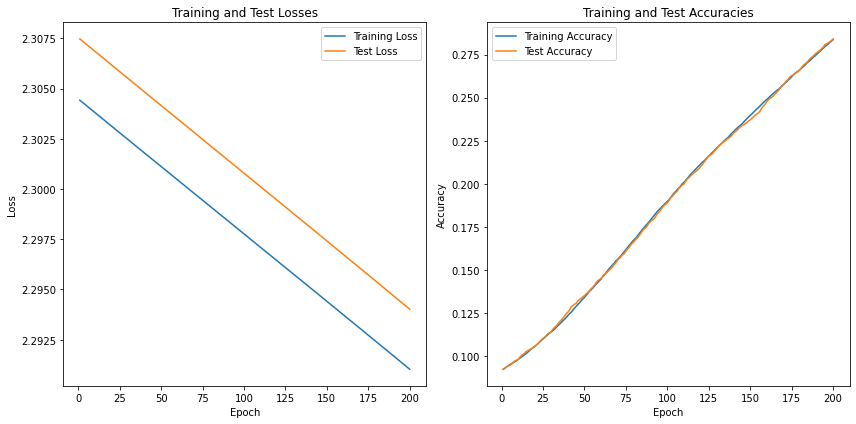

In [34]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x

# Standardize training data and save mean and std for later use
X_train, mean_train, std_train = standardize_data(X_train)

epsilon = 1e-8
# Use mean and std of training data to standardize test data
X_test = (X_test - mean_train) / (std_train + epsilon)

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    train_losses.append(train_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
#     test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    epsilon = 1e-15  # small epsilon value to avoid zero
    a2_test = np.clip(a2_test, epsilon, 1.0 - epsilon)  # clip values to avoid zero or one
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)

    test_losses.append(test_loss)
    
    # Calculate and store training accuracy
    train_predictions = np.argmax(a2, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)
    
    # Calculate and store test accuracy
    test_predictions = np.argmax(a2_test, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

with normal and standardization

Epoch 1/200, Loss: 2.3026983823133405
Epoch 2/200, Loss: 2.3026329379771737
Epoch 3/200, Loss: 2.302567499190016
Epoch 4/200, Loss: 2.302502067767688
Epoch 5/200, Loss: 2.3024366413474144
Epoch 6/200, Loss: 2.302371217458413
Epoch 7/200, Loss: 2.3023057966748848
Epoch 8/200, Loss: 2.302240379036427
Epoch 9/200, Loss: 2.302174965352597
Epoch 10/200, Loss: 2.3021095556268394
Epoch 11/200, Loss: 2.302044149982277
Epoch 12/200, Loss: 2.3019787487872425
Epoch 13/200, Loss: 2.3019133499114144
Epoch 14/200, Loss: 2.301847951233274
Epoch 15/200, Loss: 2.3017825542544497
Epoch 16/200, Loss: 2.301717159262121
Epoch 17/200, Loss: 2.3016517671437167
Epoch 18/200, Loss: 2.301586378633898
Epoch 19/200, Loss: 2.301520992962076
Epoch 20/200, Loss: 2.301455610526918
Epoch 21/200, Loss: 2.3013902304164033
Epoch 22/200, Loss: 2.3013248530166313
Epoch 23/200, Loss: 2.3012594770503347
Epoch 24/200, Loss: 2.301194101396014
Epoch 25/200, Loss: 2.3011287277546795
Epoch 26/200, Loss: 2.3010633591371037
Epoch 2

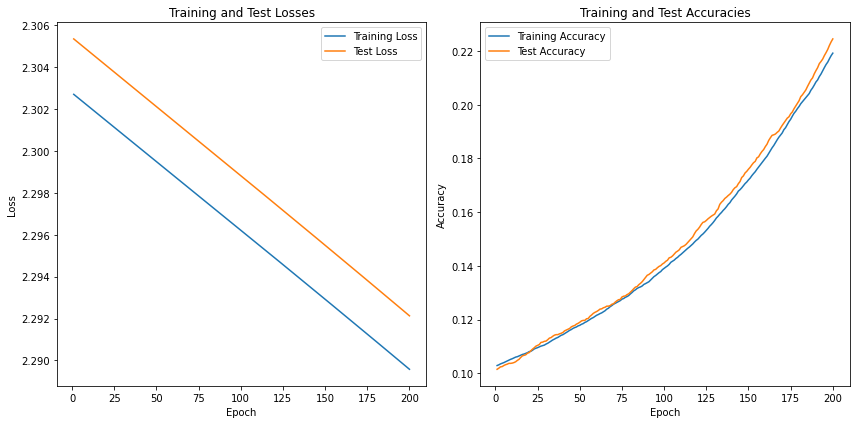

In [35]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x/255.0
X_test = test_x/255.0

# Standardize training data and save mean and std for later use
X_train, mean_train, std_train = standardize_data(X_train)

epsilon = 1e-8
# Use mean and std of training data to standardize test data
X_test = (X_test - mean_train) / (std_train + epsilon)

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    train_losses.append(train_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
#     test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    epsilon = 1e-15  # small epsilon value to avoid zero
    a2_test = np.clip(a2_test, epsilon, 1.0 - epsilon)  # clip values to avoid zero or one
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    test_losses.append(test_loss)
    
    # Calculate and store training accuracy
    train_predictions = np.argmax(a2, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)
    
    # Calculate and store test accuracy
    test_predictions = np.argmax(a2_test, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

Vanishing gradient

Epoch 1/25, Train Loss: 2.302126098964651, Test Loss: 2.3020715260370888, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch 2/25, Train Loss: 2.302124307952048, Test Loss: 2.30206965912451, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch 3/25, Train Loss: 2.302122520249792, Test Loss: 2.302067795586128, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch 4/25, Train Loss: 2.302120735851807, Test Loss: 2.3020659354158255, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch 5/25, Train Loss: 2.3021189547520358, Test Loss: 2.302064078607497, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch 6/25, Train Loss: 2.3021171769444253, Test Loss: 2.3020622251550473, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch 7/25, Train Loss: 2.302115402422939, Test Loss: 2.3020603750523927, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch 8/25, Train Loss: 2.302113631181547, Test Loss: 2.30205852829346,

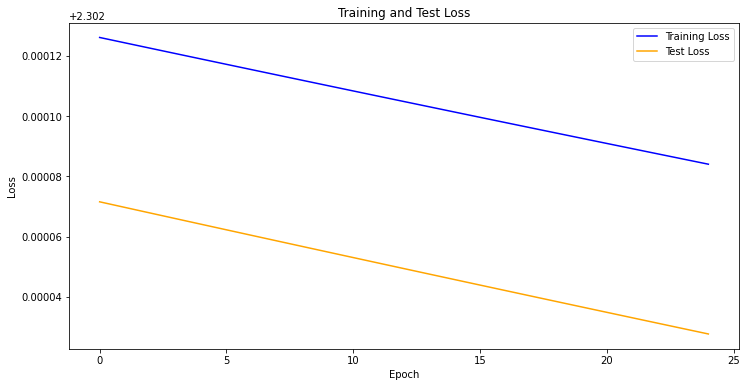

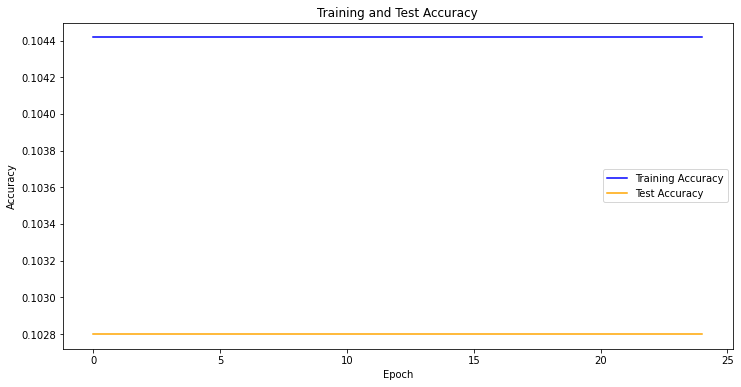

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


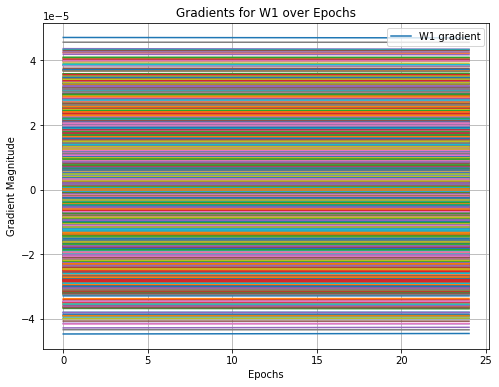

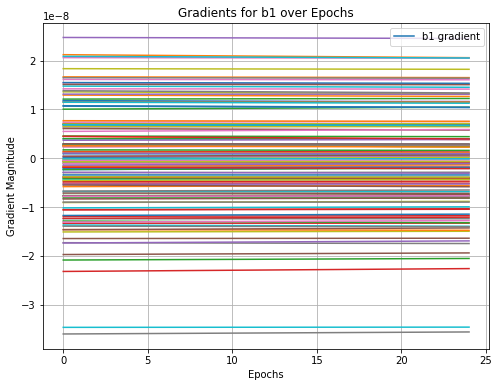

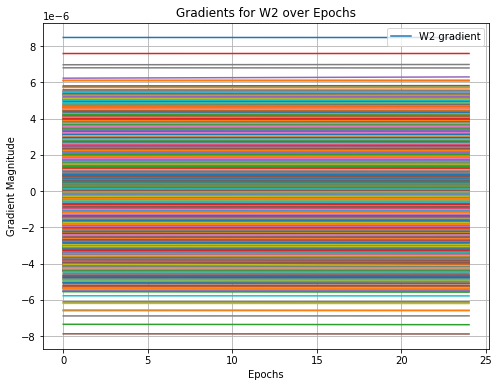

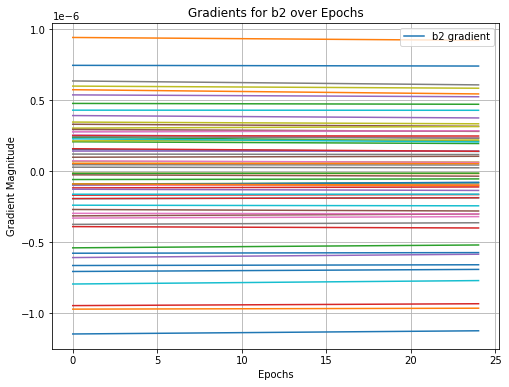

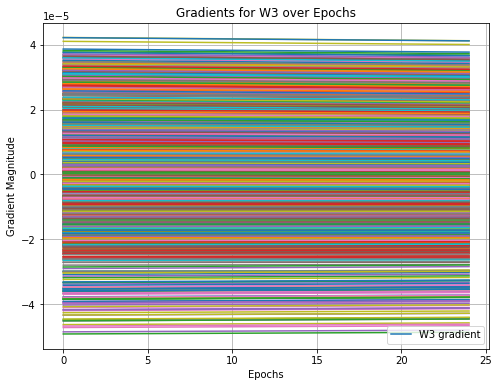

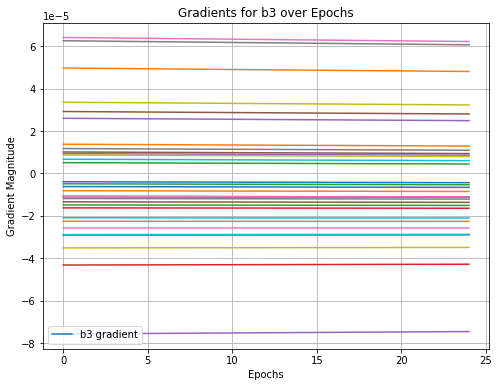

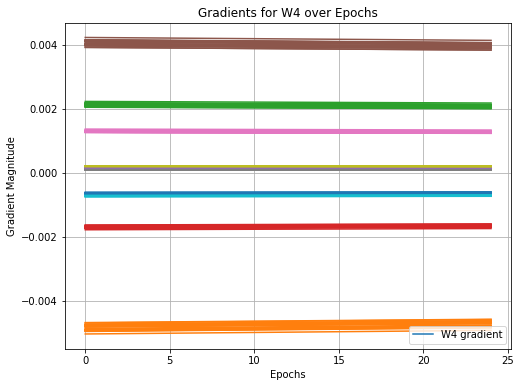

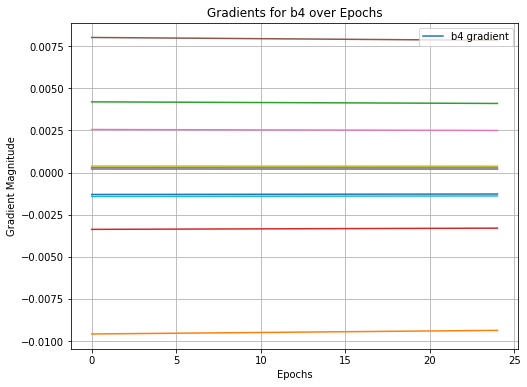

In [37]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

# Initialize lists to store gradients
gradients = []

# Load your data and preprocess it if necessary
X_train = train_x
X_test = test_x

encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32  
output_size = 10
learning_rate = 0.001
epochs = 25

W1 = random_init_s(input_size, hidden_size1)
b1 = random_init_s(1, hidden_size1)
W2 = random_init_s(hidden_size1, hidden_size2)
b2 = random_init_s(1, hidden_size2)
W3 = random_init_s(hidden_size2, hidden_size3)
b3 = random_init_s(1, hidden_size3)
W4 = random_init_s(hidden_size3, output_size)
b4 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = sigmoid(z3)
    z4 = np.dot(a3, W4) + b4
    a4 = softmax(z4)
    
    # Backpropagation
    delta4 = (a4 - y_train) / len(X_train)
    dW4 = np.dot(a3.T, delta4)
    db4 = np.sum(delta4, axis=0, keepdims=True)
    delta3 = np.dot(delta4, W4.T) * sigmoid_derivative(a3)
    dW3 = np.dot(a2.T, delta3)
    db3 = np.sum(delta3, axis=0, keepdims=True)
    delta2 = np.dot(delta3, W3.T) * sigmoid_derivative(a2)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * sigmoid_derivative(a1)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W4 -= learning_rate * dW4
    b4 -= learning_rate * db4
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a4)) / len(X_train)
    train_losses.append(train_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = sigmoid(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = sigmoid(z2_test)
    z3_test = np.dot(a2_test, W3) + b3
    a3_test = sigmoid(z3_test)
    z4_test = np.dot(a3_test, W4) + b4
    a4_test = softmax(z4_test)
    test_loss = -np.sum(y_test * np.log(a4_test)) / len(X_test)
    test_losses.append(test_loss)

    # Calculate and store training accuracy
    train_accuracy = np.mean(np.argmax(a4, axis=1) == np.argmax(y_train, axis=1))
    train_accuracies.append(train_accuracy)

    # Calculate and store test accuracy
    test_accuracy = np.mean(np.argmax(a4_test, axis=1) == np.argmax(y_test, axis=1))
    test_accuracies.append(test_accuracy)
    
    # Calculate and store gradients
    epoch_gradients = [dW1, db1, dW2, db2, dW3, db3, dW4, db4]
    gradients.append(epoch_gradients)

    # Print the losses and accuracies during training
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = sigmoid(z1)
z2 = np.dot(a1, W2) + b2
a2 = sigmoid(z2)
z3 = np.dot(a2, W3) + b3
a3 = sigmoid(z3)
z4 = np.dot(a3, W4) + b4
a4 = softmax(z4)

# Accuracy
predictions = np.argmax(a4, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and test accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Define the parameter names for plotting
parameter_names = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4']

# Plot gradients for each parameter
for i, param_name in enumerate(parameter_names):
    plt.figure(figsize=(8, 6))
    plt.title(f'Gradients for {param_name} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Gradient Magnitude')
    gradients_param = [epoch_gradients[i] for epoch_gradients in gradients]  # Extract gradients for the parameter
    
    gradients_param = np.array(gradients_param)  # Convert to numpy array
    gradients_param = gradients_param.reshape(len(gradients_param), -1)  # Reshape to 2D array

    plt.plot(range(epochs), gradients_param)
    plt.legend([f'{param_name} gradient'], loc='upper right')
    plt.grid(True)
    plt.show()

Epoch 1/25, Train Loss: 2.3020685287977156, Test Loss: 2.3022268405611217, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch 2/25, Train Loss: 2.3020668736184087, Test Loss: 2.302224918756314, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch 3/25, Train Loss: 2.3020652214268007, Test Loss: 2.3022230001789605, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch 4/25, Train Loss: 2.3020635722175626, Test Loss: 2.30222108482352, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch 5/25, Train Loss: 2.3020619259853827, Test Loss: 2.3022191726844583, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch 6/25, Train Loss: 2.302060282724951, Test Loss: 2.3022172637562535, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch 7/25, Train Loss: 2.3020586424309726, Test Loss: 2.30221535803339, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch 8/25, Train Loss: 2.3020570050981575, Test Loss: 2.3022134555103646, 

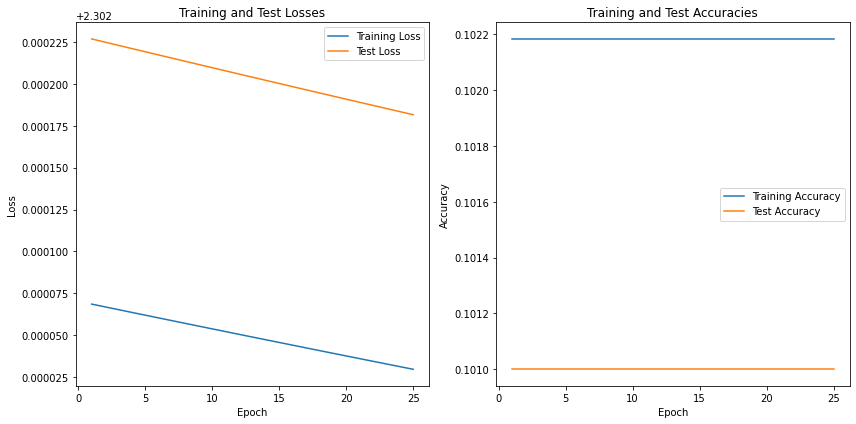

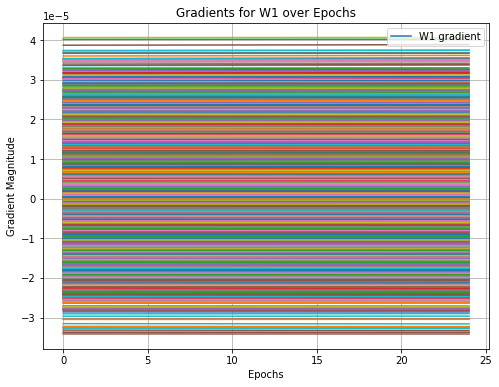

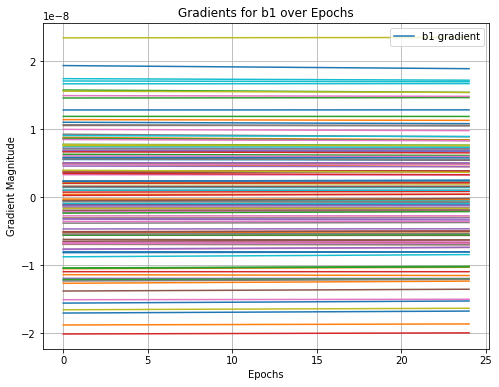

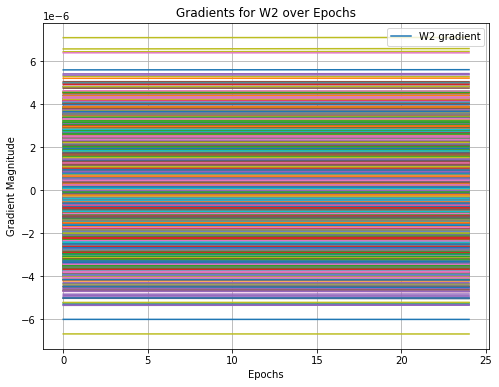

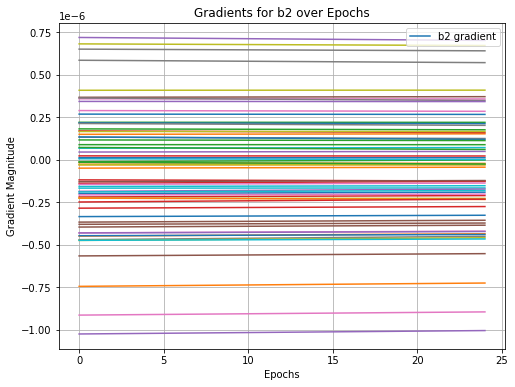

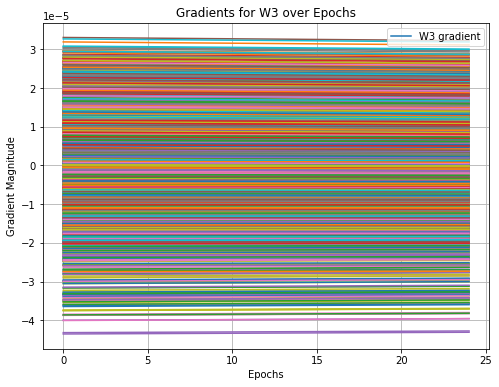

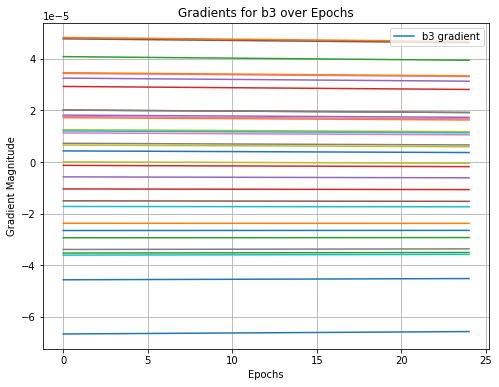

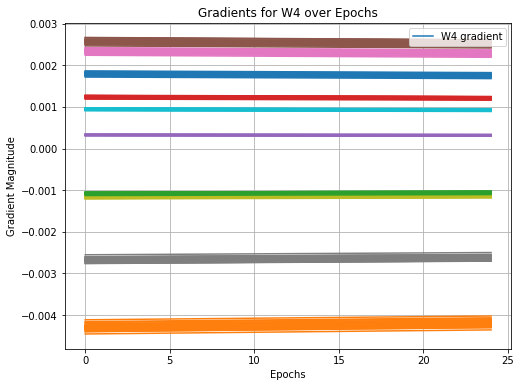

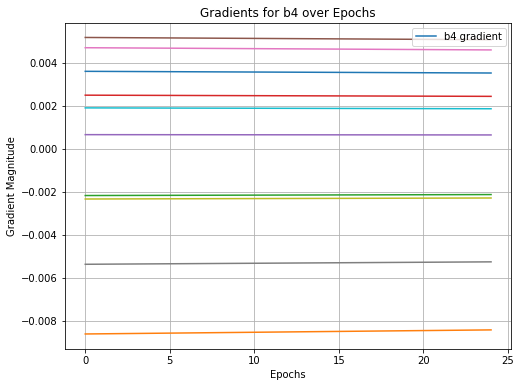

<AxesSubplot: >

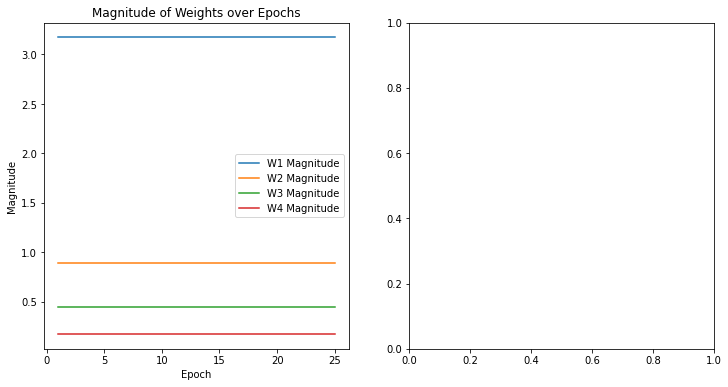

In [39]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

# Initialize lists to store gradients
gradients = []

# Initialize lists to store magnitudes of weights
magnitude_W1_list = []
magnitude_W2_list = []
magnitude_W3_list = []
magnitude_W4_list = []

# Load your data and preprocess it if necessary
X_train = train_x
X_test = test_x

encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32  
output_size = 10
learning_rate = 0.001
epochs = 25

W1 = random_init_s(input_size, hidden_size1)
b1 = random_init_s(1, hidden_size1)
W2 = random_init_s(hidden_size1, hidden_size2)
b2 = random_init_s(1, hidden_size2)
W3 = random_init_s(hidden_size2, hidden_size3)
b3 = random_init_s(1, hidden_size3)
W4 = random_init_s(hidden_size3, output_size)
b4 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = sigmoid(z3)
    z4 = np.dot(a3, W4) + b4
    a4 = softmax(z4)
    
    # Backpropagation
    delta4 = (a4 - y_train) / len(X_train)
    dW4 = np.dot(a3.T, delta4)
    db4 = np.sum(delta4, axis=0, keepdims=True)
    delta3 = np.dot(delta4, W4.T) * sigmoid_derivative(a3)
    dW3 = np.dot(a2.T, delta3)
    db3 = np.sum(delta3, axis=0, keepdims=True)
    delta2 = np.dot(delta3, W3.T) * sigmoid_derivative(a2)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * sigmoid_derivative(a1)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W4 -= learning_rate * dW4
    b4 -= learning_rate * db4
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a4)) / len(X_train)
    train_losses.append(train_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = sigmoid(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = sigmoid(z2_test)
    z3_test = np.dot(a2_test, W3) + b3
    a3_test = sigmoid(z3_test)
    z4_test = np.dot(a3_test, W4) + b4
    a4_test = softmax(z4_test)
    test_loss = -np.sum(y_test * np.log(a4_test)) / len(X_test)
    test_losses.append(test_loss)

    # Calculate and store training accuracy
    train_accuracy = np.mean(np.argmax(a4, axis=1) == np.argmax(y_train, axis=1))
    train_accuracies.append(train_accuracy)

    # Calculate and store test accuracy
    test_accuracy = np.mean(np.argmax(a4_test, axis=1) == np.argmax(y_test, axis=1))
    test_accuracies.append(test_accuracy)
    
    # Calculate and store gradients
    epoch_gradients = [dW1, db1, dW2, db2, dW3, db3, dW4, db4]
    gradients.append(epoch_gradients)
    
        # Calculate the magnitude of weights at the end of each epoch
    magnitude_W1 = np.linalg.norm(W1)
    magnitude_W2 = np.linalg.norm(W2)
    magnitude_W3 = np.linalg.norm(W3)
    magnitude_W4 = np.linalg.norm(W4)
    
    # Append magnitudes to the respective lists
    magnitude_W1_list.append(magnitude_W1)
    magnitude_W2_list.append(magnitude_W2)
    magnitude_W3_list.append(magnitude_W3)
    magnitude_W4_list.append(magnitude_W4)

    # Print the losses and accuracies during training
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = sigmoid(z1)
z2 = np.dot(a1, W2) + b2
a2 = sigmoid(z2)
z3 = np.dot(a2, W3) + b3
a3 = sigmoid(z3)
z4 = np.dot(a3, W4) + b4
a4 = softmax(z4)

# Accuracy
predictions = np.argmax(a4, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

# Define the parameter names for plotting
parameter_names = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4']

# Plot gradients for each parameter
for i, param_name in enumerate(parameter_names):
    plt.figure(figsize=(8, 6))
    plt.title(f'Gradients for {param_name} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Gradient Magnitude')
    gradients_param = [epoch_gradients[i] for epoch_gradients in gradients]  # Extract gradients for the parameter
    
    gradients_param = np.array(gradients_param)  # Convert to numpy array
    gradients_param = gradients_param.reshape(len(gradients_param), -1)  # Reshape to 2D array

    plt.plot(range(epochs), gradients_param)
    plt.legend([f'{param_name} gradient'], loc='upper right')
    plt.grid(True)
    plt.show()
    
# Plot magnitudes of weights
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), magnitude_W1_list, label='W1 Magnitude')
plt.plot(range(1, epochs+1), magnitude_W2_list, label='W2 Magnitude')
plt.plot(range(1, epochs+1), magnitude_W3_list, label='W3 Magnitude')
plt.plot(range(1, epochs+1), magnitude_W4_list, label='W4 Magnitude')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.title('Magnitude of Weights over Epochs')
plt.legend()

plt.subplot(1, 2, 2)

Regularizaion

batch normalization

<ipython-input-46-da36ea025832>:106: RuntimeWarning: divide by zero encountered in log
  test_loss = -np.sum(y_test * np.log(a2)) / (len(X_test) + epsilon)
<ipython-input-46-da36ea025832>:106: RuntimeWarning: invalid value encountered in multiply
  test_loss = -np.sum(y_test * np.log(a2)) / (len(X_test) + epsilon)


Epoch 1/200, Average Loss: 2.0142068568574603, Train Accuracy: 0.6199333333333333, Test Accuracy: 0.6254
Epoch 2/200, Average Loss: 1.8566452858538878, Train Accuracy: 0.5567, Test Accuracy: 0.5611
Epoch 3/200, Average Loss: 1.7642816828805294, Train Accuracy: 0.5032166666666666, Test Accuracy: 0.5083
Epoch 4/200, Average Loss: 1.6917159666178485, Train Accuracy: 0.4678, Test Accuracy: 0.4749
Epoch 5/200, Average Loss: 1.6322782100118591, Train Accuracy: 0.44803333333333334, Test Accuracy: 0.456
Epoch 6/200, Average Loss: 1.58189232090083, Train Accuracy: 0.43198333333333333, Test Accuracy: 0.4414
Epoch 7/200, Average Loss: 1.5381899261284735, Train Accuracy: 0.41706666666666664, Test Accuracy: 0.4246
Epoch 8/200, Average Loss: 1.4995830489404913, Train Accuracy: 0.4017833333333333, Test Accuracy: 0.4081
Epoch 9/200, Average Loss: 1.4649756393787936, Train Accuracy: 0.38771666666666665, Test Accuracy: 0.3936
Epoch 10/200, Average Loss: 1.433637571070954, Train Accuracy: 0.3755333333333

Epoch 81/200, Average Loss: 0.8925479809443162, Train Accuracy: 0.4478, Test Accuracy: 0.4514
Epoch 82/200, Average Loss: 0.8904756258740231, Train Accuracy: 0.4505, Test Accuracy: 0.4541
Epoch 83/200, Average Loss: 0.8884369875537909, Train Accuracy: 0.4531, Test Accuracy: 0.4556
Epoch 84/200, Average Loss: 0.8864313201511324, Train Accuracy: 0.45543333333333336, Test Accuracy: 0.4578
Epoch 85/200, Average Loss: 0.8844592906845462, Train Accuracy: 0.4574666666666667, Test Accuracy: 0.4598
Epoch 86/200, Average Loss: 0.8825190900571855, Train Accuracy: 0.4595166666666667, Test Accuracy: 0.4628
Epoch 87/200, Average Loss: 0.8806078300488992, Train Accuracy: 0.46141666666666664, Test Accuracy: 0.4649
Epoch 88/200, Average Loss: 0.8787292774569732, Train Accuracy: 0.46345, Test Accuracy: 0.4678
Epoch 89/200, Average Loss: 0.876880646381174, Train Accuracy: 0.4653, Test Accuracy: 0.4701
Epoch 90/200, Average Loss: 0.8750610884930737, Train Accuracy: 0.46785, Test Accuracy: 0.473
Epoch 91/2

Epoch 161/200, Average Loss: 0.7870256305956392, Train Accuracy: 0.5758833333333333, Test Accuracy: 0.5782
Epoch 162/200, Average Loss: 0.7861088554146084, Train Accuracy: 0.57715, Test Accuracy: 0.5798
Epoch 163/200, Average Loss: 0.7851979157692658, Train Accuracy: 0.5779, Test Accuracy: 0.5809
Epoch 164/200, Average Loss: 0.7842921622503934, Train Accuracy: 0.5789333333333333, Test Accuracy: 0.582
Epoch 165/200, Average Loss: 0.7833910492280756, Train Accuracy: 0.5798833333333333, Test Accuracy: 0.5829
Epoch 166/200, Average Loss: 0.7824962803948762, Train Accuracy: 0.58065, Test Accuracy: 0.5841
Epoch 167/200, Average Loss: 0.7816084856398743, Train Accuracy: 0.5815833333333333, Test Accuracy: 0.5852
Epoch 168/200, Average Loss: 0.7807236410075046, Train Accuracy: 0.5825166666666667, Test Accuracy: 0.5861
Epoch 169/200, Average Loss: 0.7798414645889328, Train Accuracy: 0.5837, Test Accuracy: 0.5865
Epoch 170/200, Average Loss: 0.7789651057425162, Train Accuracy: 0.5848166666666667,

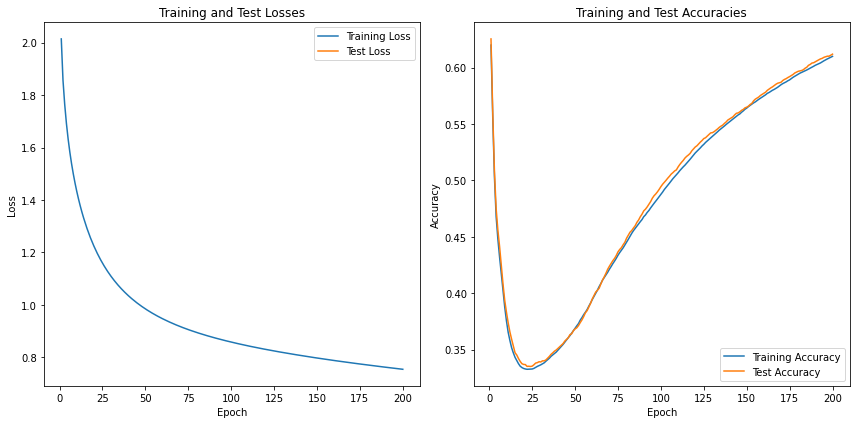

In [46]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

batch_size = 32
epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size))
beta1 = np.zeros((1, hidden_size))
gamma2 = np.ones((1, output_size))
beta2 = np.zeros((1, output_size))

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = softmax(gamma2 * z2_norm + beta2)
        
        # Backpropagation
        delta2 = (a2 - y_batch) / len(X_batch)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = np.dot(delta2, W2.T) * (z1 > 0)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a2)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)
        
        # Calculate loss for the current batch and add it to the total loss for the epoch
        batch_loss = -np.sum(y_batch * np.log(a2)) / len(X_batch)
        total_loss += batch_loss
    
    # Average loss over all batches for the epoch
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_losses.append(avg_loss)  # Store training loss for the epoch
    
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2_train = softmax(z2)
    
    # Calculate training accuracy for the epoch
    train_predictions = np.argmax(a2_train, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch

    # Testing
    z1 = np.dot(X_test, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)

    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a2)) / (len(X_test) + epsilon)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Calculate test accuracy
    test_predictions = np.argmax(a2, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch

    # Print average loss for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
from sklearn.preprocessing import OneHotEncoder

X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.00001
epochs = 40

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

batch_size = 256

epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size))
beta1 = np.zeros((1, hidden_size))
gamma2 = np.ones((1, output_size))
beta2 = np.zeros((1, output_size))

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = softmax(gamma2 * z2_norm + beta2)
        
        # Backpropagation
        delta2 = (a2 - y_batch) / len(X_batch)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = np.dot(delta2, W2.T) * (z1 > 0)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a2)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)

    # Average loss over all batches
    avg_loss = total_loss / (len(X_train) / batch_size)
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')


Epoch 1/40, Average Loss: 2.5184624500789847
Epoch 2/40, Average Loss: 2.0952388021044834
Epoch 3/40, Average Loss: 1.8182994998425621
Epoch 4/40, Average Loss: 1.6347502062633104
Epoch 5/40, Average Loss: 1.5078618609066516
Epoch 6/40, Average Loss: 1.4165771900532733
Epoch 7/40, Average Loss: 1.3486674011884554
Epoch 8/40, Average Loss: 1.2967505155957797
Epoch 9/40, Average Loss: 1.2561573320788164
Epoch 10/40, Average Loss: 1.2238161422607736
Epoch 11/40, Average Loss: 1.197593437415725
Epoch 12/40, Average Loss: 1.1759755079202447
Epoch 13/40, Average Loss: 1.157888090907266
Epoch 14/40, Average Loss: 1.1425962003605414
Epoch 15/40, Average Loss: 1.1295420883558727
Epoch 16/40, Average Loss: 1.1183259444642129
Epoch 17/40, Average Loss: 1.1086192488835207
Epoch 18/40, Average Loss: 1.1001836188239
Epoch 19/40, Average Loss: 1.0928106161615077
Epoch 20/40, Average Loss: 1.0863247480835083
Epoch 21/40, Average Loss: 1.0805738884691862
Epoch 22/40, Average Loss: 1.0754441986503802
Ep

Epoch 1/40, Average Loss: 2.471998030388801
Epoch 2/40, Average Loss: 2.103597996088035
Epoch 3/40, Average Loss: 1.8298265921228118
Epoch 4/40, Average Loss: 1.6386706015651595
Epoch 5/40, Average Loss: 1.5064875501239485
Epoch 6/40, Average Loss: 1.413629120798347
Epoch 7/40, Average Loss: 1.3464995165958116
Epoch 8/40, Average Loss: 1.2964636652289534
Epoch 9/40, Average Loss: 1.2581325631053155
Epoch 10/40, Average Loss: 1.2280483528114579
Epoch 11/40, Average Loss: 1.2039165730871693
Epoch 12/40, Average Loss: 1.184246855912587
Epoch 13/40, Average Loss: 1.1679847241480583
Epoch 14/40, Average Loss: 1.1544023076242151
Epoch 15/40, Average Loss: 1.1429790359559944
Epoch 16/40, Average Loss: 1.1333259772043907
Epoch 17/40, Average Loss: 1.125111379253467
Epoch 18/40, Average Loss: 1.1180713886325564
Epoch 19/40, Average Loss: 1.111978836311296
Epoch 20/40, Average Loss: 1.1066553271857076
Epoch 21/40, Average Loss: 1.1019820379411676
Epoch 22/40, Average Loss: 1.0978326829344935
Epo

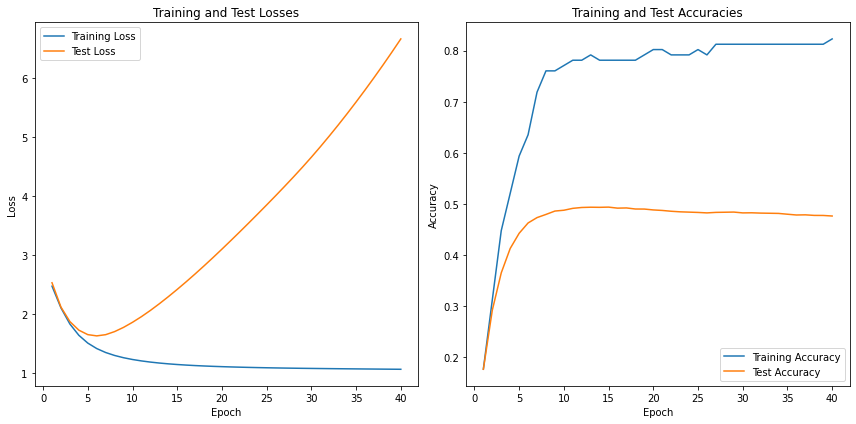

In [48]:
X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.00001
epochs = 40

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

batch_size = 256

epsilon = 1e-8

# Batch normalization parameters
gamma1 = np.ones((1, hidden_size))
beta1 = np.zeros((1, hidden_size))
gamma2 = np.ones((1, output_size))
beta2 = np.zeros((1, output_size))

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    total_loss = 0.0  # Initialize total loss for the epoch
    for i in range(0, len(X_train), batch_size):
        # Forward propagation
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        z1 = np.dot(X_batch, W1) + b1
        z1_norm = (z1 - np.mean(z1, axis=0)) / np.sqrt(np.var(z1, axis=0) + epsilon)
        a1 = relu(gamma1 * z1_norm + beta1)

        z2 = np.dot(a1, W2) + b2
        z2_norm = (z2 - np.mean(z2, axis=0)) / np.sqrt(np.var(z2, axis=0) + epsilon)
        a2 = softmax(gamma2 * z2_norm + beta2)
        
        # Backpropagation
        delta2 = (a2 - y_batch) / len(X_batch)
        dW2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = np.dot(delta2, W2.T) * (z1 > 0)
        dW1 = np.dot(X_batch.T, delta1)
        db1 = np.sum(delta1, axis=0)

        # Calculate loss for the current batch
        batch_loss = -np.sum(y_batch * np.log(a2)) / len(X_batch)
        total_loss += batch_loss

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        
        # Update batch normalization parameters
        gamma1 -= learning_rate * np.sum(delta1 * z1_norm, axis=0)
        beta1 -= learning_rate * np.sum(delta1, axis=0)
        gamma2 -= learning_rate * np.sum(delta2 * z2_norm, axis=0)
        beta2 -= learning_rate * np.sum(delta2, axis=0)

    # Average loss over all batches
    avg_loss = total_loss / (len(X_train) / batch_size)
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}')
    
    # Calculate and store training loss
    train_losses.append(avg_loss)
    
    # Calculate and store test loss
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    test_losses.append(test_loss)

    # Calculate and store training accuracy
    train_accuracy = np.mean(np.argmax(a2, axis=1) == np.argmax(y_batch, axis=1))
    train_accuracies.append(train_accuracy)

    # Calculate and store test accuracy
    test_accuracy = np.mean(np.argmax(a2_test, axis=1) == np.argmax(y_test, axis=1))
    test_accuracies.append(test_accuracy)
    
# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

# Plot training and test losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

dropout

In [76]:
X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.00001
epochs = 40

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

dropout_prob = 0.5  # Dropout probability

# Training loop
for epoch in range(epochs):
    # Forward propagation with dropout
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    # Apply dropout to the first hidden layer
    mask1 = np.random.rand(*a1.shape) < dropout_prob
    a1 *= mask1
    a1 /= dropout_prob  # Scale the activations
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
    
    # Compute and print the magnitude of weights at the end of each epoch
    magnitude_W1 = np.linalg.norm(W1)
    magnitude_W2 = np.linalg.norm(W2)
    print(f'Magnitude of W1 at epoch {epoch+1}: {magnitude_W1}')
    print(f'Magnitude of W2 at epoch {epoch+1}: {magnitude_W2}')

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

Epoch 1/40, Loss: 4.506199890324251
Magnitude of W1 at epoch 1: 3.1812969996982963
Magnitude of W2 at epoch 1: 0.3497426650751772
Epoch 2/40, Loss: 4.499534612531277
Magnitude of W1 at epoch 2: 3.1812925776814036
Magnitude of W2 at epoch 2: 0.34964595373855334
Epoch 3/40, Loss: 4.464862825890604
Magnitude of W1 at epoch 3: 3.1812882436498797
Magnitude of W2 at epoch 3: 0.349550443633007
Epoch 4/40, Loss: 4.432146661846454
Magnitude of W1 at epoch 4: 3.181283998246424
Magnitude of W2 at epoch 4: 0.34945595962538284
Epoch 5/40, Loss: 4.428968878786856
Magnitude of W1 at epoch 5: 3.1812798235774866
Magnitude of W2 at epoch 5: 0.3493616266021123
Epoch 6/40, Loss: 4.395224024715794
Magnitude of W1 at epoch 6: 3.181275705522661
Magnitude of W2 at epoch 6: 0.34926827199421606
Epoch 7/40, Loss: 4.390351253371531
Magnitude of W1 at epoch 7: 3.1812716756761645
Magnitude of W2 at epoch 7: 0.3491751691242157
Epoch 8/40, Loss: 4.379814660120789
Magnitude of W1 at epoch 8: 3.1812677264935347
Magnitu

Epoch 1/40, Loss: 4.6127501255566346, Train Accuracy: 0.10191666666666667, Test Accuracy: 0.0949
Epoch 2/40, Loss: 4.59466796937844, Train Accuracy: 0.10243333333333333, Test Accuracy: 0.0959
Epoch 3/40, Loss: 4.571689458071467, Train Accuracy: 0.1024, Test Accuracy: 0.0967
Epoch 4/40, Loss: 4.543596124232211, Train Accuracy: 0.10363333333333333, Test Accuracy: 0.0981
Epoch 5/40, Loss: 4.516796217129875, Train Accuracy: 0.10553333333333334, Test Accuracy: 0.0987
Epoch 6/40, Loss: 4.505247956878365, Train Accuracy: 0.10551666666666666, Test Accuracy: 0.0999
Epoch 7/40, Loss: 4.478783308732025, Train Accuracy: 0.10438333333333333, Test Accuracy: 0.1013
Epoch 8/40, Loss: 4.442492210903177, Train Accuracy: 0.10613333333333333, Test Accuracy: 0.1023
Epoch 9/40, Loss: 4.419556477813505, Train Accuracy: 0.10813333333333333, Test Accuracy: 0.103
Epoch 10/40, Loss: 4.395795324900196, Train Accuracy: 0.10801666666666666, Test Accuracy: 0.1045
Epoch 11/40, Loss: 4.377658510506505, Train Accuracy:

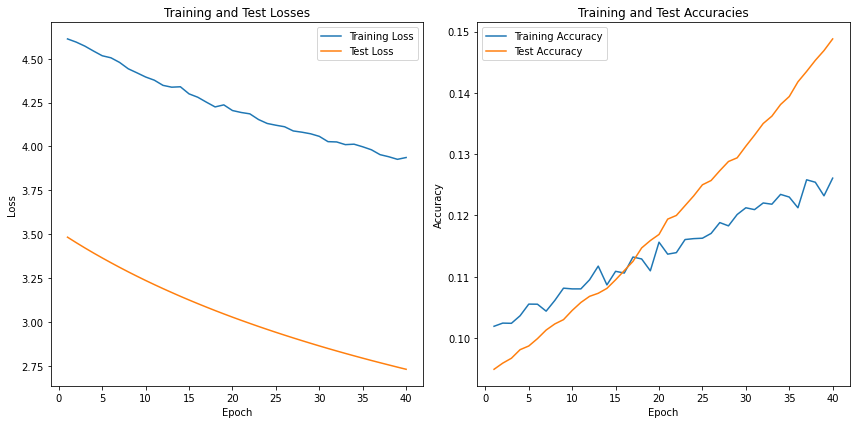

In [53]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.00001
epochs = 40
dropout_prob = 0.5  # Dropout probability

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

# Training loop
for epoch in range(epochs):
    # Forward propagation with dropout during training
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    # Apply dropout to the first hidden layer
    mask1 = np.random.rand(*a1.shape) < dropout_prob
    a1 *= mask1
    a1 /= dropout_prob  # Scale the activations
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate training loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    train_losses.append(loss)  # Store training loss for the epoch
    
    # Compute training accuracy
    train_predictions = np.argmax(a2, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)  # Store training accuracy for the epoch
    
    # Testing (without dropout)
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
    
    # Calculate test loss
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    test_losses.append(test_loss)  # Store test loss for the epoch
    
    # Compute test accuracy
    test_predictions = np.argmax(a2_test, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)  # Store test accuracy for the epoch
    
    # Print loss and accuracy for the epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

early stopping

In [78]:
X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 20

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

best_loss = np.inf
best_W1 = None
best_b1 = None
best_W2 = None
best_b2 = None
patience = 5  # Number of epochs to wait before stopping if the loss doesn't improve
wait = 0  # Counter for patience

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
    
    # Compute and print the magnitude of weights at the end of each epoch
    magnitude_W1 = np.linalg.norm(W1)
    magnitude_W2 = np.linalg.norm(W2)
    print(f'Magnitude of W1 at epoch {epoch+1}: {magnitude_W1}')
    print(f'Magnitude of W2 at epoch {epoch+1}: {magnitude_W2}')
    
    # Early stopping
    if loss < best_loss:
        best_loss = loss
        best_W1 = W1.copy()
        best_b1 = b1.copy()
        best_W2 = W2.copy()
        best_b2 = b2.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

Epoch 1/20, Loss: 3.2321759723313668
Magnitude of W1 at epoch 1: 3.181437507188835
Magnitude of W2 at epoch 1: 0.35104177766542843
Epoch 2/20, Loss: 2.7410802208010074
Magnitude of W1 at epoch 2: 3.1811775552795183
Magnitude of W2 at epoch 2: 0.34889585390392963
Epoch 3/20, Loss: 2.001666490736634
Magnitude of W1 at epoch 3: 3.1811370390047657
Magnitude of W2 at epoch 3: 0.34863022498748186
Epoch 4/20, Loss: 1.5966465604737883
Magnitude of W1 at epoch 4: 3.1811961825207202
Magnitude of W2 at epoch 4: 0.3492384948556014
Epoch 5/20, Loss: 1.4264993498245961
Magnitude of W1 at epoch 5: 3.181273927465106
Magnitude of W2 at epoch 5: 0.3499709617247497
Epoch 6/20, Loss: 1.2677927562343845
Magnitude of W1 at epoch 6: 3.181371294805863
Magnitude of W2 at epoch 6: 0.35088866967745874
Epoch 7/20, Loss: 1.1625417832284615
Magnitude of W1 at epoch 7: 3.1814738754513034
Magnitude of W2 at epoch 7: 0.3518307078022065
Epoch 8/20, Loss: 1.0773830019187494
Magnitude of W1 at epoch 8: 3.1815809078373736

In [81]:
X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 60

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

best_loss = np.inf
best_W1 = None
best_b1 = None
best_W2 = None
best_b2 = None
patience = 5  # Number of epochs to wait before stopping if the loss doesn't improve
wait = 0  # Counter for patience

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
    
    # Compute and print the magnitude of weights at the end of each epoch
    magnitude_W1 = np.linalg.norm(W1)
    magnitude_W2 = np.linalg.norm(W2)
    print(f'Magnitude of W1 at epoch {epoch+1}: {magnitude_W1}')
    print(f'Magnitude of W2 at epoch {epoch+1}: {magnitude_W2}')
    
    # Early stopping
    if loss < best_loss:
        best_loss = loss
        best_W1 = W1.copy()
        best_b1 = b1.copy()
        best_W2 = W2.copy()
        best_b2 = b2.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

Epoch 1/60, Loss: 3.604447531591841
Magnitude of W1 at epoch 1: 3.168524681549293
Magnitude of W2 at epoch 1: 0.34600247324848116
Epoch 2/60, Loss: 2.7657475484115133
Magnitude of W1 at epoch 2: 3.168288082239463
Magnitude of W2 at epoch 2: 0.3439043497123704
Epoch 3/60, Loss: 2.1247648926891904
Magnitude of W1 at epoch 3: 3.1682387057787094
Magnitude of W2 at epoch 3: 0.34348882465309283
Epoch 4/60, Loss: 1.7245827729802377
Magnitude of W1 at epoch 4: 3.168246119837264
Magnitude of W2 at epoch 4: 0.34352047876776026
Epoch 5/60, Loss: 1.4785525406920226
Magnitude of W1 at epoch 5: 3.168324054840154
Magnitude of W2 at epoch 5: 0.3442250047988533
Epoch 6/60, Loss: 1.331566893385233
Magnitude of W1 at epoch 6: 3.1683989882385806
Magnitude of W2 at epoch 6: 0.3449180060310722
Epoch 7/60, Loss: 1.2149959697917494
Magnitude of W1 at epoch 7: 3.168501239497735
Magnitude of W2 at epoch 7: 0.34584361767400873
Epoch 8/60, Loss: 1.1438574707822842
Magnitude of W1 at epoch 8: 3.168587223730138
Mag

In [82]:
X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 100

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

best_loss = np.inf
best_W1 = None
best_b1 = None
best_W2 = None
best_b2 = None
patience = 5  # Number of epochs to wait before stopping if the loss doesn't improve
wait = 0  # Counter for patience

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
    
    # Compute and print the magnitude of weights at the end of each epoch
    magnitude_W1 = np.linalg.norm(W1)
    magnitude_W2 = np.linalg.norm(W2)
    print(f'Magnitude of W1 at epoch {epoch+1}: {magnitude_W1}')
    print(f'Magnitude of W2 at epoch {epoch+1}: {magnitude_W2}')
    
    # Early stopping
    if loss < best_loss:
        best_loss = loss
        best_W1 = W1.copy()
        best_b1 = b1.copy()
        best_W2 = W2.copy()
        best_b2 = b2.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

Epoch 1/100, Loss: 3.400738705430545
Magnitude of W1 at epoch 1: 3.1744079619829138
Magnitude of W2 at epoch 1: 0.3655071497619669
Epoch 2/100, Loss: 3.014993950347358
Magnitude of W1 at epoch 2: 3.174101390538924
Magnitude of W2 at epoch 2: 0.3632968338014914
Epoch 3/100, Loss: 2.2801786564293556
Magnitude of W1 at epoch 3: 3.1740144770313683
Magnitude of W2 at epoch 3: 0.36269138582846105
Epoch 4/100, Loss: 1.8834689760265781
Magnitude of W1 at epoch 4: 3.1739621899530257
Magnitude of W2 at epoch 4: 0.3623330505589547
Epoch 5/100, Loss: 1.5140644736448563
Magnitude of W1 at epoch 5: 3.174021654522418
Magnitude of W2 at epoch 5: 0.3628934034104745
Epoch 6/100, Loss: 1.3924797602292973
Magnitude of W1 at epoch 6: 3.174077903118765
Magnitude of W2 at epoch 6: 0.3634637651921413
Epoch 7/100, Loss: 1.23929259989515
Magnitude of W1 at epoch 7: 3.1741672318275125
Magnitude of W2 at epoch 7: 0.3642318867276945
Epoch 8/100, Loss: 1.123824531105767
Magnitude of W1 at epoch 8: 3.174253328244718

Epoch 62/100, Loss: 0.41077136515563856
Magnitude of W1 at epoch 62: 3.177403107866652
Magnitude of W2 at epoch 62: 0.3916650168737264
Epoch 63/100, Loss: 0.4085577489020448
Magnitude of W1 at epoch 63: 3.1774385328350276
Magnitude of W2 at epoch 63: 0.3919513570250992
Epoch 64/100, Loss: 0.4063976764506316
Magnitude of W1 at epoch 64: 3.1774735571324673
Magnitude of W2 at epoch 64: 0.39223426434830905
Epoch 65/100, Loss: 0.4042889836818102
Magnitude of W1 at epoch 65: 3.177508194629624
Magnitude of W2 at epoch 65: 0.39251385740818606
Epoch 66/100, Loss: 0.4022295738669637
Magnitude of W1 at epoch 66: 3.1775424556533176
Magnitude of W2 at epoch 66: 0.39279022879245834
Epoch 67/100, Loss: 0.4002179637039062
Magnitude of W1 at epoch 67: 3.177576353104508
Magnitude of W2 at epoch 67: 0.39306348384130113
Epoch 68/100, Loss: 0.39825019738967277
Magnitude of W1 at epoch 68: 3.1776098984842562
Magnitude of W2 at epoch 68: 0.39333372373760334
Epoch 69/100, Loss: 0.3963249532320001
Magnitude of

In [84]:
X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 200

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

best_loss = np.inf
best_W1 = None
best_b1 = None
best_W2 = None
best_b2 = None
patience = 5  # Number of epochs to wait before stopping if the loss doesn't improve
wait = 0  # Counter for patience

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
    
    # Compute and print the magnitude of weights at the end of each epoch
    magnitude_W1 = np.linalg.norm(W1)
    magnitude_W2 = np.linalg.norm(W2)
    print(f'Magnitude of W1 at epoch {epoch+1}: {magnitude_W1}')
    print(f'Magnitude of W2 at epoch {epoch+1}: {magnitude_W2}')
    
    # Early stopping
    if loss < best_loss:
        best_loss = loss
        best_W1 = W1.copy()
        best_b1 = b1.copy()
        best_W2 = W2.copy()
        best_b2 = b2.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

Epoch 1/200, Loss: 3.4228932520148376
Magnitude of W1 at epoch 1: 3.1670644200392957
Magnitude of W2 at epoch 1: 0.35289835387387625
Epoch 2/200, Loss: 3.2343589986073056
Magnitude of W1 at epoch 2: 3.1667232442235806
Magnitude of W2 at epoch 2: 0.3511916391953676
Epoch 3/200, Loss: 2.7400940700660086
Magnitude of W1 at epoch 3: 3.166514818121668
Magnitude of W2 at epoch 3: 0.3502348365229107
Epoch 4/200, Loss: 2.3240433969865224
Magnitude of W1 at epoch 4: 3.166387720006402
Magnitude of W2 at epoch 4: 0.34950058507068865
Epoch 5/200, Loss: 1.6823482080092762
Magnitude of W1 at epoch 5: 3.166402374362855
Magnitude of W2 at epoch 5: 0.34992372789605125
Epoch 6/200, Loss: 1.4757690874145801
Magnitude of W1 at epoch 6: 3.166434514648523
Magnitude of W2 at epoch 6: 0.35031014121348286
Epoch 7/200, Loss: 1.1163663688632774
Magnitude of W1 at epoch 7: 3.166523253734398
Magnitude of W2 at epoch 7: 0.3511700198176558
Epoch 8/200, Loss: 0.9914591826628625
Magnitude of W1 at epoch 8: 3.166634776

Epoch 62/200, Loss: 0.40692808188914076
Magnitude of W1 at epoch 62: 3.1697864506119773
Magnitude of W2 at epoch 62: 0.37993203332728936
Epoch 63/200, Loss: 0.404816031361834
Magnitude of W1 at epoch 63: 3.1698228600922245
Magnitude of W2 at epoch 63: 0.3802347493724206
Epoch 64/200, Loss: 0.40275391147818623
Magnitude of W1 at epoch 64: 3.1698588989452197
Magnitude of W2 at epoch 64: 0.380534149905649
Epoch 65/200, Loss: 0.40073926636251594
Magnitude of W1 at epoch 65: 3.1698945889882193
Magnitude of W2 at epoch 65: 0.3808304420946365
Epoch 66/200, Loss: 0.3987695018370055
Magnitude of W1 at epoch 66: 3.169929930759053
Magnitude of W2 at epoch 66: 0.38112361862900856
Epoch 67/200, Loss: 0.3968423096745483
Magnitude of W1 at epoch 67: 3.1699649421607514
Magnitude of W2 at epoch 67: 0.3814138501337157
Epoch 68/200, Loss: 0.3949560040182535
Magnitude of W1 at epoch 68: 3.169999626826439
Magnitude of W2 at epoch 68: 0.38170116146324956
Epoch 69/200, Loss: 0.3931103725480429
Magnitude of W

Epoch 123/200, Loss: 0.32818932026429737
Magnitude of W1 at epoch 123: 3.171581348514006
Magnitude of W2 at epoch 123: 0.3945911012116892
Epoch 124/200, Loss: 0.3273610045044254
Magnitude of W1 at epoch 124: 3.171606236935922
Magnitude of W2 at epoch 124: 0.3947906830857124
Epoch 125/200, Loss: 0.32654075846273123
Magnitude of W1 at epoch 125: 3.1716310353613366
Magnitude of W2 at epoch 125: 0.39498944678939246
Epoch 126/200, Loss: 0.32572890355864964
Magnitude of W1 at epoch 126: 3.1716557453406944
Magnitude of W2 at epoch 126: 0.3951874053378926
Epoch 127/200, Loss: 0.324924944044864
Magnitude of W1 at epoch 127: 3.1716803677972436
Magnitude of W2 at epoch 127: 0.3953845676433982
Epoch 128/200, Loss: 0.3241288560359304
Magnitude of W1 at epoch 128: 3.171704903481261
Magnitude of W2 at epoch 128: 0.3955809403572415
Epoch 129/200, Loss: 0.3233401988839612
Magnitude of W1 at epoch 129: 3.171729353839984
Magnitude of W2 at epoch 129: 0.39577653640386784
Epoch 130/200, Loss: 0.32255893925

Epoch 183/200, Loss: 0.28908781442386594
Magnitude of W1 at epoch 183: 3.172957051165998
Magnitude of W2 at epoch 183: 0.40548022553847113
Epoch 184/200, Loss: 0.288567367293271
Magnitude of W1 at epoch 184: 3.172978532182658
Magnitude of W2 at epoch 184: 0.40564800632072007
Epoch 185/200, Loss: 0.2880503631757247
Magnitude of W1 at epoch 185: 3.172999980418523
Magnitude of W2 at epoch 185: 0.4058154633754536
Epoch 186/200, Loss: 0.2875362017885461
Magnitude of W1 at epoch 186: 3.173021396664658
Magnitude of W2 at epoch 186: 0.4059826037581142
Epoch 187/200, Loss: 0.28702511528164715
Magnitude of W1 at epoch 187: 3.1730427813083844
Magnitude of W2 at epoch 187: 0.40614943066822884
Epoch 188/200, Loss: 0.286517000794713
Magnitude of W1 at epoch 188: 3.1730641347294335
Magnitude of W2 at epoch 188: 0.40631594786457936
Epoch 189/200, Loss: 0.28601188731665517
Magnitude of W1 at epoch 189: 3.1730854572236056
Magnitude of W2 at epoch 189: 0.40648215731829096
Epoch 190/200, Loss: 0.285509377

In [ ]:
X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 600

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

best_loss = np.inf
best_W1 = None
best_b1 = None
best_W2 = None
best_b2 = None
patience = 5  # Number of epochs to wait before stopping if the loss doesn't improve
wait = 0  # Counter for patience

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and print loss
    loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
    
    # Compute and print the magnitude of weights at the end of each epoch
    magnitude_W1 = np.linalg.norm(W1)
    magnitude_W2 = np.linalg.norm(W2)
    print(f'Magnitude of W1 at epoch {epoch+1}: {magnitude_W1}')
    print(f'Magnitude of W2 at epoch {epoch+1}: {magnitude_W2}')
    
    # Early stopping
    if loss < best_loss:
        best_loss = loss
        best_W1 = W1.copy()
        best_b1 = b1.copy()
        best_W2 = W2.copy()
        best_b2 = b2.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Testing
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = softmax(z2)

# Accuracy
predictions = np.argmax(a2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == actual)
print(f'Test Accuracy: {accuracy}')

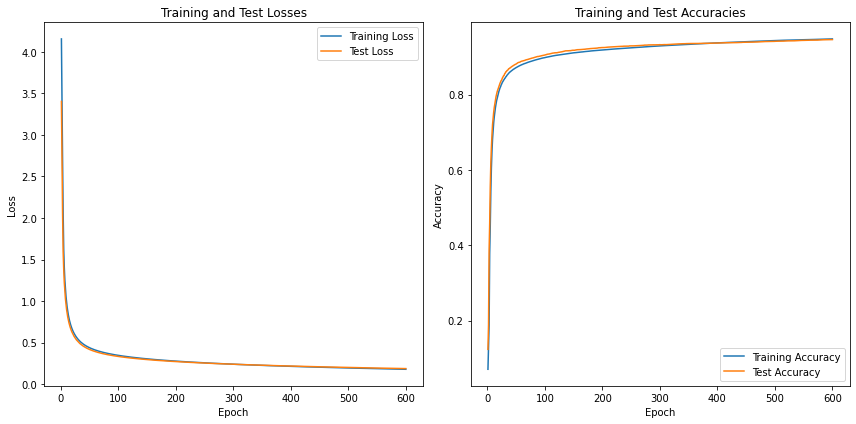

In [55]:
# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Initialize lists to store training and test accuracies
train_accuracies = []
test_accuracies = []

X_train = train_x
X_test = test_x

# One-hot encode labels
encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(train_y.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(test_y.reshape(-1,1)).toarray()

# Neural Network Parameters
input_size = 784
hidden_size = 128
output_size = 10
learning_rate = 0.001
epochs = 600

# Initialize weights and biases
W1 = random_init_s(input_size, hidden_size)
b1 = random_init_s(1, hidden_size)
W2 = random_init_s(hidden_size, output_size)
b2 = random_init_s(1, output_size)

best_loss = np.inf
best_W1 = None
best_b1 = None
best_W2 = None
best_b2 = None
patience = 5  # Number of epochs to wait before stopping if the loss doesn't improve
wait = 0  # Counter for patience

# Training loop
for epoch in range(epochs):
    # Forward propagation
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    # Backpropagation
    delta2 = (a2 - y_train) / len(X_train)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)
    delta1 = np.dot(delta2, W2.T) * (z1 > 0)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Calculate and store training loss
    train_loss = -np.sum(y_train * np.log(a2)) / len(X_train)
    train_losses.append(train_loss)
    
    # Compute training accuracy
    train_predictions = np.argmax(a2, axis=1)
    train_actual = np.argmax(y_train, axis=1)
    train_accuracy = np.mean(train_predictions == train_actual)
    train_accuracies.append(train_accuracy)
    
    # Testing
    z1_test = np.dot(X_test, W1) + b1
    a1_test = relu(z1_test)
    z2_test = np.dot(a1_test, W2) + b2
    a2_test = softmax(z2_test)
    
    # Calculate and store test loss
    test_loss = -np.sum(y_test * np.log(a2_test)) / len(X_test)
    test_losses.append(test_loss)
    
    # Compute test accuracy
    test_predictions = np.argmax(a2_test, axis=1)
    test_actual = np.argmax(y_test, axis=1)
    test_accuracy = np.mean(test_predictions == test_actual)
    test_accuracies.append(test_accuracy)
    
    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        best_W1 = W1.copy()
        best_b1 = b1.copy()
        best_W2 = W2.copy()
        best_b2 = b2.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
print(train_accuracies[-1])

0.9481
